# Quantitative Methods Written Investigation

## CASA0007: Quantitative Methods

### Student: Hansen Wiguna - ucfnwig

## 1. Research Question

What factors impact the number of arts and culture facilities in London and how can it be quantified?

## 2. Setting Up Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Set up Caching Function

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that we don't need to remember to
    do so ourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th time.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split 
        # but it doesn't work with lists... 
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## 3. Load Data

### 3.1 London Ward Shapefile Data

Source of london ward shapefile data is from London Data Store: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

In [3]:
#open all columns
pd.set_option('display.max_columns', None)

In [4]:
ward_shp = gpd.read_file('data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')
ward_shp.head(3)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.17,0.00,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.46,0.00,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.39,0.00,"POLYGON ((518107.499 167303.399, 518114.301 16..."


In [5]:
ward_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        633 non-null    object  
 1   GSS_CODE    633 non-null    object  
 2   DISTRICT    633 non-null    object  
 3   LAGSSCODE   633 non-null    object  
 4   HECTARES    633 non-null    float64 
 5   NONLD_AREA  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


<AxesSubplot:>

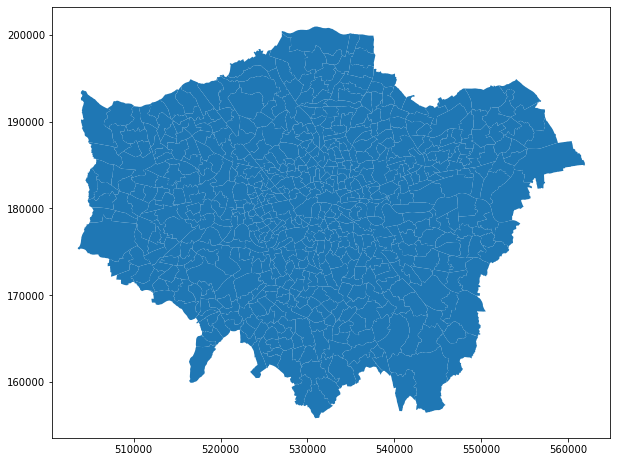

In [6]:
# Check the data
ward_shp.plot(figsize=(10,8))

### 3.2 Cultural venues by London Borough/Ward

Source from London Data Store: https://data.london.gov.uk/download/cultural-infrastructure-map/debe429f-c76b-41d0-bf96-c859fbb8a8a4/site_by_borough.zip 

In [7]:
cultural_venues = pd.read_csv('data/all_sites.csv')
cultural_venues.head(3)

,BOROUGH,Cultural Venue Type,additional_contact_name,address1,address2,address3,alternativenames,borough_code,borough_name,building_name,contact_name,easting,fid_london_ward,greenflagcommunityaward,gss_code,latitude,longitude,northing,os_addressbase_uprn,rm_organisation_name,runtime,site_name,ward,ward_2018_code,ward_2018_name,ward_code,ward_code_2018,ward_name_2018,website
0,Tower Hamlets,Archives,NaN,Thomson Reuters,30 South Colonnade,Canary Wharf,NaN,E09000030,Tower Hamlets,NaN,NaN,"537,486.96",NaN,NaN,E09000030,51.50,-0.02,"180,236.92","6,155,377.00",NaN,04/20/2020,Reuters Archive,NaN,E05009323,Canary Wharf,NaN,NaN,NaN,https://reuters.screenocean.com/
1,Tower Hamlets,Archives,NaN,Whitechapel High Street,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,NaN,"533,979.96",NaN,NaN,E09000030,51.52,-0.07,"181,455.92","6,000,113.00",NaN,04/20/2020,Whitechapel Art Gallery,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.whitechapelgallery.org/
2,Tower Hamlets,Archives,NaN,37 Spital Square,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,NaN,"533,412.96",NaN,NaN,E09000030,51.52,-0.08,"181,891.92","6,001,685.00",NaN,04/20/2020,Society for the Protection of Ancient Buildings,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.spab.org.uk/


In [8]:
cultural_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BOROUGH                  10003 non-null  object 
 1   Cultural Venue Type      10003 non-null  object 
 2   additional_contact_name  11 non-null     object 
 3   address1                 9842 non-null   object 
 4   address2                 7807 non-null   object 
 5   address3                 3764 non-null   object 
 6   alternativenames         0 non-null      float64
 7   borough_code             9901 non-null   object 
 8   borough_name             9948 non-null   object 
 9   building_name            1 non-null      object 
 10  contact_name             147 non-null    object 
 11  easting                  10003 non-null  float64
 12  fid_london_ward          5 non-null      float64
 13  greenflagcommunityaward  0 non-null      float64
 14  gss_code              

### 3.3 Ward Atlas Data

Source from Ward Atlas Data: https://data.london.gov.uk/dataset/ward-profiles-and-atlas 

Variables:
- population density (persons per sq km, 2018)
- average income (mean household income, 2012)
- employment rate (Employment rate 16-64 years old, 2011)
- average gcse score (2014)

In [9]:
ward_atlas = pd.read_csv('data/warddata.csv', sep=';', decimal=',')
ward_atlas.head(3)

,ward_code,ward_name,population_density,average_income,employment_rate,avg_gcse_score
0,E09000001,City of London,"2,546.90","99,390.00",79.63,354.50
1,E05000026,Abbey,"12,038.50","38,870.00",60.35,317.66
2,E05000027,Alibon,"7,357.10","37,290.00",63.11,307.45


In [10]:
ward_atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           625 non-null    object 
 1   ward_name           625 non-null    object 
 2   population_density  625 non-null    float64
 3   average_income      625 non-null    float64
 4   employment_rate     625 non-null    float64
 5   avg_gcse_score      625 non-null    float64
dtypes: float64(4), object(2)
memory usage: 29.4+ KB


## 4. Data Wrangling / Preparation

### 4.1 Group Cultural Activities Data per Ward

In [11]:
groupby_cult = cultural_venues.groupby('ward_2018_code').gss_code.agg(Count='count').reset_index()
#check output
groupby_cult.head()

,ward_2018_code,Count
0,E05000026,14
1,E05000027,1
2,E05000028,1
3,E05000029,7
4,E05000030,4


In [12]:
groupby_cult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ward_2018_code  702 non-null    object
 1   Count           702 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


### 4.2 Join Cultural Facilities Data with Ward Atlas Data

In [13]:
# Join groupby_cult with ward_atlas data

comb1 = groupby_cult.merge(ward_atlas, left_on='ward_2018_code', right_on='ward_code', how='left')
#check output
comb1.head(3)

,ward_2018_code,Count,ward_code,ward_name,population_density,average_income,employment_rate,avg_gcse_score
0,E05000026,14,E05000026,Abbey,"12,038.50","38,870.00",60.35,317.66
1,E05000027,1,E05000027,Alibon,"7,357.10","37,290.00",63.11,307.45
2,E05000028,1,E05000028,Becontree,"10,076.90","37,860.00",61.19,295.45


In [14]:
#rearranging columns neatly
comb1 = comb1[['ward_code', 'ward_name', 'Count', 'population_density', 'average_income', 'employment_rate', 'avg_gcse_score']]

In [15]:
# rename columns
comb1.rename(
    columns={"Count": "cultural_facilities"},
    inplace=True,
)
#check output
comb1.head(3)

,ward_code,ward_name,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score
0,E05000026,Abbey,14,"12,038.50","38,870.00",60.35,317.66
1,E05000027,Alibon,1,"7,357.10","37,290.00",63.11,307.45
2,E05000028,Becontree,1,"10,076.90","37,860.00",61.19,295.45


In [16]:
comb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 701
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ward_code            532 non-null    object 
 1   ward_name            532 non-null    object 
 2   cultural_facilities  702 non-null    int64  
 3   population_density   532 non-null    float64
 4   average_income       532 non-null    float64
 5   employment_rate      532 non-null    float64
 6   avg_gcse_score       532 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 43.9+ KB


In [17]:
comb1.describe()

,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score
count,702.00,532.00,532.00,532.00,532.00
mean,13.98,"8,187.39","51,313.05",69.86,327.20
std,27.28,"4,916.21","13,650.68",6.39,21.65
min,1.00,189.70,"32,250.00",46.11,279.87
25%,4.00,"4,564.92","41,620.00",65.55,311.32
50%,8.00,"6,889.25","48,525.00",70.50,323.84
75%,15.00,"10,901.58","57,212.50",74.83,340.73
max,413.00,"30,125.00","176,950.00",83.90,396.21


### 4.3 Data Preparation for Multiple Regression

In [18]:
#copy comb1 data into df_reg
df_reg = comb1.copy()

In [19]:
# add columns of ln income and ln house prices
df_reg['ln_population_density'] = np.log(df_reg['population_density'])
df_reg['ln_average_income'] = np.log(df_reg['average_income'])

#drop average income and house prices columns
df_reg.drop(columns=['population_density', 'average_income'], inplace=True)

#check output 
df_reg.head(3)

,ward_code,ward_name,cultural_facilities,employment_rate,avg_gcse_score,ln_population_density,ln_average_income
0,E05000026,Abbey,14,60.35,317.66,9.40,10.57
1,E05000027,Alibon,1,63.11,307.45,8.90,10.53
2,E05000028,Becontree,1,61.19,295.45,9.22,10.54


In [20]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 701
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ward_code              532 non-null    object 
 1   ward_name              532 non-null    object 
 2   cultural_facilities    702 non-null    int64  
 3   employment_rate        532 non-null    float64
 4   avg_gcse_score         532 non-null    float64
 5   ln_population_density  532 non-null    float64
 6   ln_average_income      532 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 43.9+ KB


In [21]:
# Drop NaN values
df_reg = df_reg.dropna()
print(df_reg)

     ward_code       ward_name  cultural_facilities  employment_rate  \
0    E05000026           Abbey                   14            60.35   
1    E05000027          Alibon                    1            63.11   
2    E05000028       Becontree                    1            61.19   
3    E05000029  Chadwell Heath                    7            63.64   
4    E05000030       Eastbrook                    4            68.22   
..         ...             ...                  ...              ...   
527  E05000645       Tachbrook                   11            75.19   
528  E05000646  Vincent Square                   17            69.02   
529  E05000647         Warwick                   33            73.77   
530  E05000648      Westbourne                   17            59.00   
531  E05000649        West End                  385            71.34   

     avg_gcse_score  ln_population_density  ln_average_income  
0            317.66                   9.40              10.57  
1      

### 4.4 Data Preparation for Clustering

In [22]:
#this dataset is standardised, based off comb1
df_cluster = comb1.copy()

In [23]:
# standardise cluster_df
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

columns = ['cultural_facilities', 'population_density', 'average_income', 'employment_rate', 'avg_gcse_score']

df_cluster[columns] = mms.fit_transform(df_cluster[columns])
#.values.reshape(-1,1)

#check output
df_cluster.head(3)

,ward_code,ward_name,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score
0,E05000026,Abbey,0.03,0.40,0.05,0.38,0.32
1,E05000027,Alibon,0.00,0.24,0.03,0.45,0.24
2,E05000028,Becontree,0.00,0.33,0.04,0.40,0.13


In [24]:
df_cluster.drop(['ward_name'], axis=1, inplace=True)

In [25]:
df_cluster.set_index('ward_code', inplace=True)
df_cluster.head(3)

,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score
ward_code,,,,,
E05000026,0.03,0.40,0.05,0.38,0.32
E05000027,0.00,0.24,0.03,0.45,0.24
E05000028,0.00,0.33,0.04,0.40,0.13


In [26]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, E05000026 to nan
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cultural_facilities  702 non-null    float64
 1   population_density   532 non-null    float64
 2   average_income       532 non-null    float64
 3   employment_rate      532 non-null    float64
 4   avg_gcse_score       532 non-null    float64
dtypes: float64(5)
memory usage: 32.9+ KB


In [27]:
# Drop NaN values
df_cluster = df_cluster.dropna()
print(df_cluster)

           cultural_facilities  population_density  average_income  \
ward_code                                                            
E05000026                 0.03                0.40            0.05   
E05000027                 0.00                0.24            0.03   
E05000028                 0.00                0.33            0.04   
E05000029                 0.01                0.09            0.05   
E05000030                 0.01                0.09            0.07   
...                        ...                 ...             ...   
E05000645                 0.02                0.71            0.33   
E05000646                 0.04                0.51            0.32   
E05000647                 0.08                0.54            0.37   
E05000648                 0.04                0.64            0.15   
E05000649                 0.93                0.19            0.44   

           employment_rate  avg_gcse_score  
ward_code                                   

## 5. Analysis

### 5.1 Multiple Linear Regression between various independent variables against dependent variable of cultural_facilities

#### 5.1.1 Check the correlation between variables

In [28]:
#correlation coefficients between variables
df_reg.corr()

,cultural_facilities,employment_rate,avg_gcse_score,ln_population_density,ln_average_income
cultural_facilities,1.00,-0.07,0.07,0.10,0.26
employment_rate,-0.07,1.00,0.52,-0.25,0.58
avg_gcse_score,0.07,0.52,1.00,-0.20,0.60
ln_population_density,0.10,-0.25,-0.20,1.00,-0.00
ln_average_income,0.26,0.58,0.60,-0.00,1.00


In [29]:
#creating df for correlation, mainly dropping msoa code and name from df_reg
df_corr = df_reg.copy(deep=True)
df_corr = df_corr.drop(columns=['ward_code', 'ward_name'])
df_corr.head(3)

,cultural_facilities,employment_rate,avg_gcse_score,ln_population_density,ln_average_income
0,14,60.35,317.66,9.40,10.57
1,1,63.11,307.45,8.90,10.53
2,1,61.19,295.45,9.22,10.54


Text(0.5, 1.0, 'Correlation Matrix')

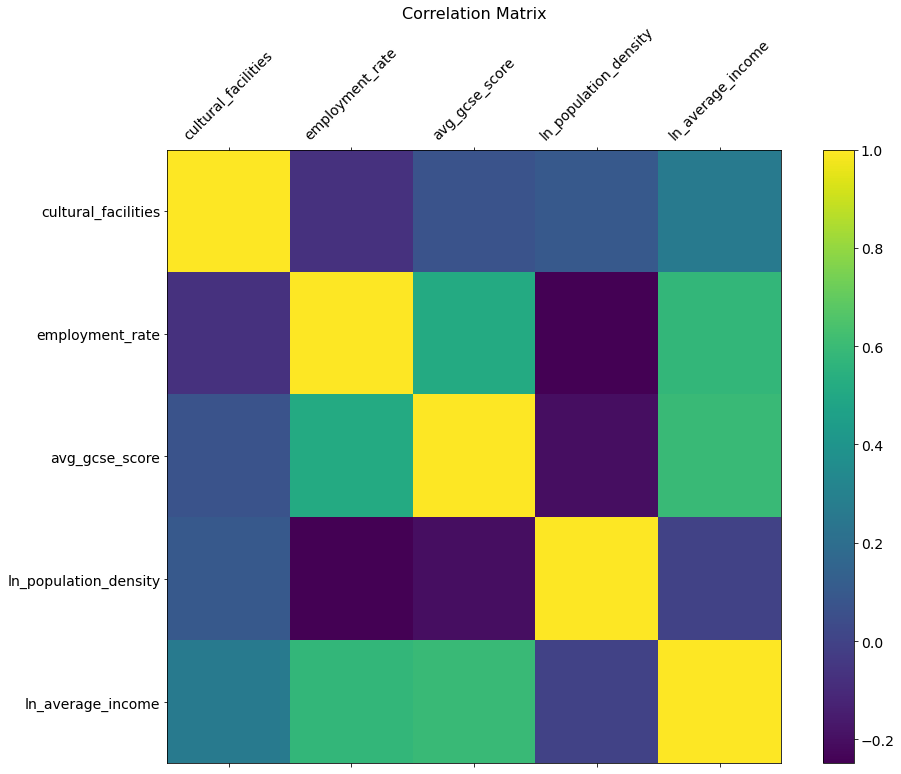

In [30]:
# Correlation Matrix
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(15, 11))
plt.matshow(df_reg.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

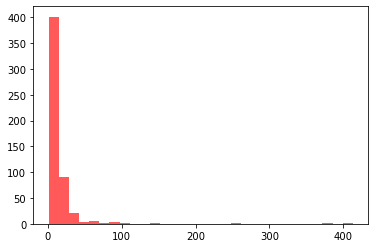

In [31]:
# Check distribution plot

# plotting histogram
plt.hist(df_reg['cultural_facilities'],bins = 30,
         alpha = 0.65, color = 'red')
plt.show()

#### 5.1.2 Scatter Plot

<AxesSubplot:xlabel='ln_average_income', ylabel='cultural_facilities'>

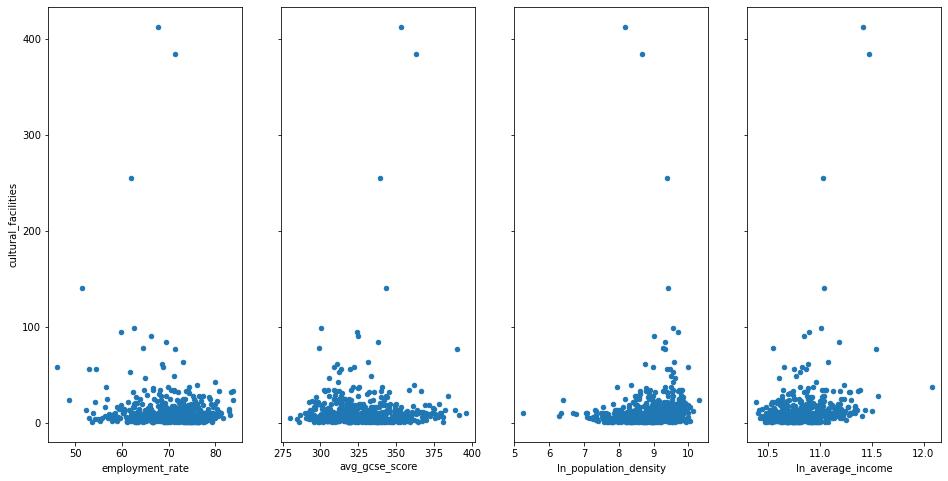

In [32]:
fig, axs = plt.subplots(1, 4, sharey=True)
df_reg.plot(kind='scatter', x='employment_rate', y='cultural_facilities', ax=axs[0], figsize=(16, 8))
df_reg.plot(kind='scatter', x='avg_gcse_score', y='cultural_facilities', ax=axs[1] )
df_reg.plot(kind='scatter', x='ln_population_density', y='cultural_facilities', ax=axs[2])
df_reg.plot(kind='scatter', x='ln_average_income', y='cultural_facilities', ax=axs[3])

#### 5.1.3 Calculate VIF

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features):
    
    X = df_reg[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
        
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

compute_vif(['employment_rate', 'avg_gcse_score', 'ln_population_density', 'ln_average_income'])

/tmp/ipykernel_8221/1776575500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,employment_rate,1.73
1,avg_gcse_score,1.73
2,ln_population_density,1.14
3,ln_average_income,1.96


#### 5.1.4 Multiple Regression
We run a multiple linear regression of cultural facilities against employment rate, average GCSE score, population density, and average income.  

In [34]:
model_reg = smf.ols('cultural_facilities ~ employment_rate + avg_gcse_score + ln_population_density + ln_average_income', 
                        df_reg).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cultural_facilities   R-squared:                       0.149
Model:                             OLS   Adj. R-squared:                  0.143
Method:                  Least Squares   F-statistic:                     23.08
Date:                 Mon, 16 Jan 2023   Prob (F-statistic):           1.37e-17
Time:                         14:01:14   Log-Likelihood:                -2512.9
No. Observations:                  532   AIC:                             5036.
Df Residuals:                      527   BIC:                             5057.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -525.6662     61.685     -8.522      0.000    -646.844    -404.488
employment_rate          -1.5068      0.244     -6.168      0.000      -1.987      -1.027
avg_gcse_score           -0.0607      0.072     -0.842      0.400      -0.202       0.081
ln_population_density     0.4979      1.854      0.269      0.788      -3.143       4.139
ln_average_income        61.0208      7.146      8.539      0.000      46.983      75.059
==============================================================================
Omnibus:                      838.329   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260872.895
Skew:                           8.986   Prob(JB):                         0.00
Kurtosis:                     109.985   Cond. No.                     1.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5.2 Clustering

K-Means eucledian distance, sensitive with outliers, formula use quadrat square. We use a standardised dataset for clustering. 

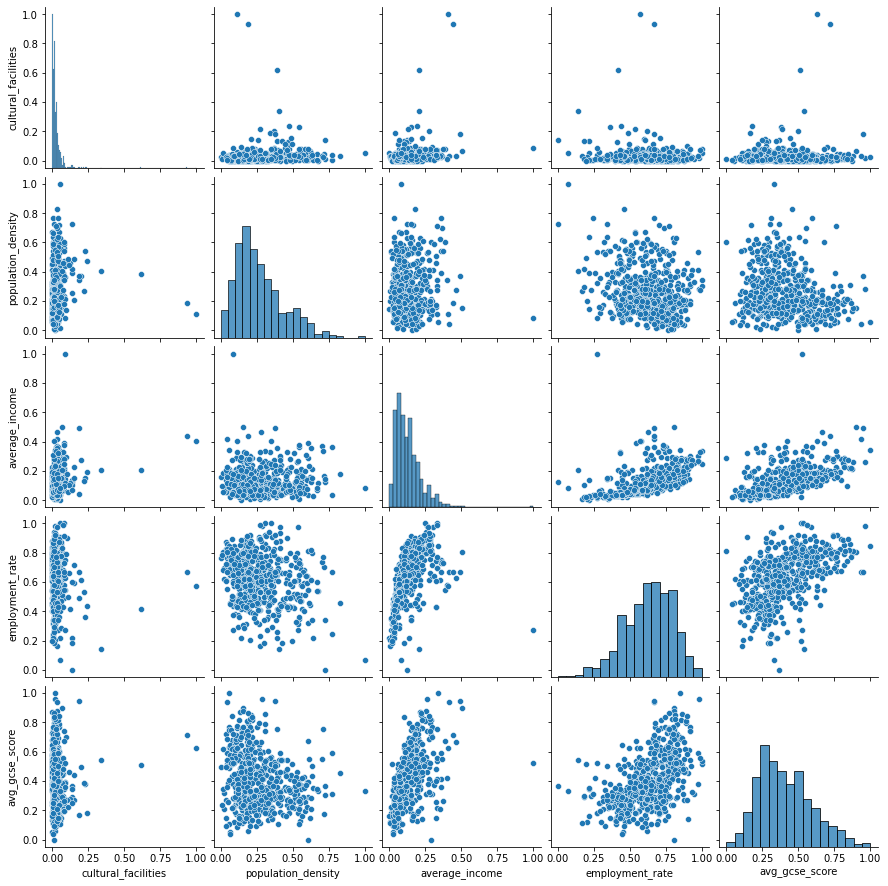

In [35]:
#check distribution plot for standardised dataset
sns.pairplot(df_cluster)

In [36]:
from sklearn.cluster import KMeans

In [37]:
# How many cluster - Using Silhouette 
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [38]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_cluster)
    score = silhouette_score(df_cluster, kmeans.labels_)
    silhouette_coefficients.append(score)

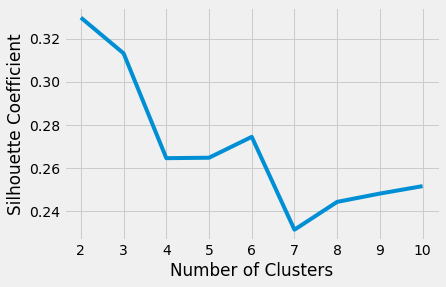

In [39]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [40]:
#Elbow method
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_cluster)
    sse.append(kmeans.inertia_)

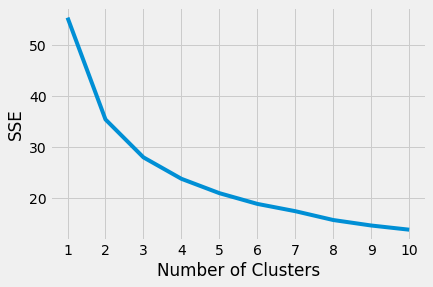

In [41]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [42]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [43]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [44]:
kmeans.fit(df_cluster)

KMeans(init='random', n_clusters=3, random_state=42)

In [45]:
kmeans.cluster_centers_

array([[0.03101967, 0.18188738, 0.18896218, 0.7660705 , 0.595271  ],
       [0.01999176, 0.20953286, 0.07473406, 0.55112317, 0.28190194],
       [0.05045224, 0.5167212 , 0.147474  , 0.55132584, 0.33829582]])

In [46]:
kmeans.labels_

array([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0,
       1, 2, 2, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [47]:
df_cluster['cluster'] = pd.Series(kmeans.labels_, index=df_cluster.index)

In [48]:
df_cluster['cluster'] = df_cluster['cluster'] + 1

In [49]:
#check output
df_cluster.head(10)

,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score,cluster
ward_code,,,,,,
E05000026,0.03,0.40,0.05,0.38,0.32,3
E05000027,0.00,0.24,0.03,0.45,0.24,2
E05000028,0.00,0.33,0.04,0.40,0.13,2
E05000029,0.01,0.09,0.05,0.46,0.12,2
E05000030,0.01,0.09,0.07,0.59,0.22,2
E05000031,0.00,0.27,0.04,0.41,0.31,2
E05000032,0.01,0.54,0.01,0.27,0.18,3
E05000033,0.01,0.28,0.04,0.46,0.19,2
E05000034,0.01,0.18,0.03,0.41,0.15,2


In [50]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, E05000026 to E05000649
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cultural_facilities  532 non-null    float64
 1   population_density   532 non-null    float64
 2   average_income       532 non-null    float64
 3   employment_rate      532 non-null    float64
 4   avg_gcse_score       532 non-null    float64
 5   cluster              532 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 27.0+ KB


In [51]:
# Joining with shp file

cluster_shp = pd.merge(ward_shp, df_cluster, left_on='GSS_CODE', right_on='ward_code', how='left')
cluster_shp.head(3)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score,cluster
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.17,0.00,"POLYGON ((516401.596 160201.802, 516407.302 16...",0.01,0.04,0.11,0.86,0.36,1.00
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.46,0.00,"POLYGON ((519552.998 164295.600, 519508.096 16...",0.00,0.14,0.11,0.80,0.50,1.00
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.39,0.00,"POLYGON ((518107.499 167303.399, 518114.301 16...",0.02,0.22,0.15,0.76,0.54,1.00


In [52]:
#check datatype
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 633 entries, 0 to 632
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   NAME                 633 non-null    object  
 1   GSS_CODE             633 non-null    object  
 2   DISTRICT             633 non-null    object  
 3   LAGSSCODE            633 non-null    object  
 4   HECTARES             633 non-null    float64 
 5   NONLD_AREA           633 non-null    float64 
 6   geometry             633 non-null    geometry
 7   cultural_facilities  480 non-null    float64 
 8   population_density   480 non-null    float64 
 9   average_income       480 non-null    float64 
 10  employment_rate      480 non-null    float64 
 11  avg_gcse_score       480 non-null    float64 
 12  cluster              480 non-null    float64 
dtypes: float64(8), geometry(1), object(4)
memory usage: 69.2+ KB


In [53]:
cluster_shp['cluster'] = cluster_shp['cluster'].astype(str)

In [54]:
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 633 entries, 0 to 632
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   NAME                 633 non-null    object  
 1   GSS_CODE             633 non-null    object  
 2   DISTRICT             633 non-null    object  
 3   LAGSSCODE            633 non-null    object  
 4   HECTARES             633 non-null    float64 
 5   NONLD_AREA           633 non-null    float64 
 6   geometry             633 non-null    geometry
 7   cultural_facilities  480 non-null    float64 
 8   population_density   480 non-null    float64 
 9   average_income       480 non-null    float64 
 10  employment_rate      480 non-null    float64 
 11  avg_gcse_score       480 non-null    float64 
 12  cluster              633 non-null    object  
dtypes: float64(7), geometry(1), object(5)
memory usage: 69.2+ KB


<AxesSubplot:>

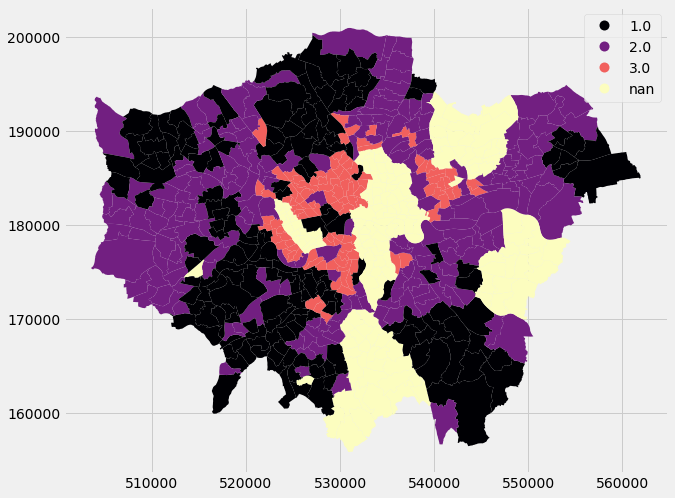

In [55]:
# Plotting
cluster_shp.plot(column='cluster', cmap='magma', edgecolor='none', legend=True, figsize=(12,8))

In [56]:
df_cluster.groupby("cluster").mean()

,cultural_facilities,population_density,average_income,employment_rate,avg_gcse_score
cluster,,,,,
1,0.03,0.18,0.19,0.77,0.60
2,0.02,0.21,0.07,0.55,0.28
3,0.05,0.52,0.15,0.55,0.34
